# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions, providing the python code in the cell below.

In [3]:
df = pd.read_csv('footballer_data.csv')

# Drop the columns
columns_drop = ['ID', 'club', 'club_logo', 'birth_date', 'flag', 'nationality', 'photo', 'potential']
df = df.drop(columns=columns_drop)

# Hint: In order to get dummies, you can first convert the column with strings to Categorical type using pandas,
# using a specific set of categories
columns_dummy = ['work_rate_att', 'work_rate_def', 'preferred_foot']
df = pd.get_dummies(df, columns=columns_dummy, drop_first=True)
df.head()

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,0,0,1,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,0,1,0,1,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,0,0,0,1,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,0,0,0,1,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,0,1,0,1,1


### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors on the original data that result if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the losses (absolute errors) and print their mean and standard deviation.

Mean Absolute Error (Baseline): 5.491330443481161
Standard Deviation of Errors (Baseline): 4.2618861864489475


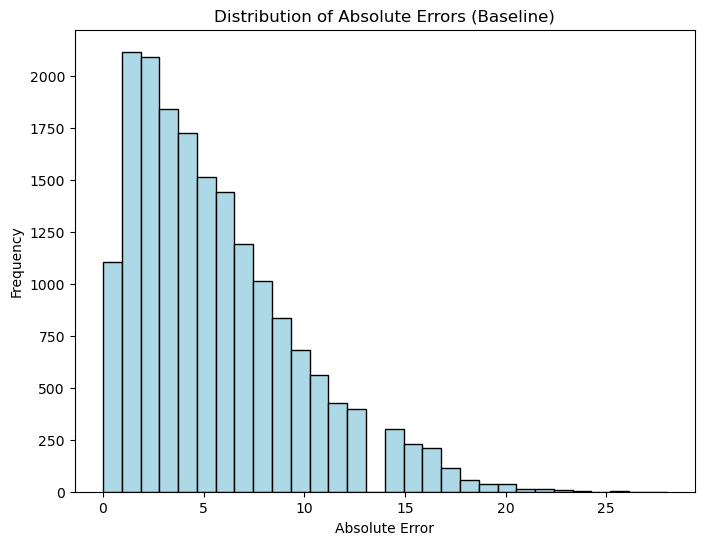

In [21]:
# Define mean absolute error function  
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
# Compute baseline predictions using median of the 'overall' column
median_overall = df['overall'].median()
# Predict median for all players
y_pred_baseline = np.full_like(df['overall'], median_overall)
# Compute absolute errors
absolute_errors = np.abs(df['overall'] - y_pred_baseline)

# Get mean and std of test loss 
mean_error = np.mean(absolute_errors)
std_error = np.std(absolute_errors)

print(f"Mean Absolute Error (Baseline): {mean_error:}")
print(f"Standard Deviation of Errors (Baseline): {std_error:}")

# Plot distribution  
plt.figure(figsize=(8, 6))
plt.hist(absolute_errors, bins=30, color='lightblue', edgecolor='black')
plt.title("Distribution of Absolute Errors (Baseline)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()

### Question 2: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like you to choose the test set size so that the estimate of the performance of the final selected model is known to within $\pm 0.25$ units at a 95% confidence interval, using mean absolute error as the loss function of choice.

Recall that a CLT-based $95\%$ confidence interval for a mean is given by:

$ \bar{x} \pm \frac{1.96 \sigma_l}{\sqrt{n}}$,

If we equate the right hand side to $d$ and re-arrange, we can choose the test set size using the following formula, which gives the test size ($n_\mathrm{test}$) needed for a confidence interval to have width ($\pm d$) if the standard deviation of the loss is $\sigma_l$:

$ n_\textrm{test} = \left(\frac{1.96 \sigma_l}{d}\right)^2$.

Decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [9]:
# Given values
d = 0.25
sigma_l = std_error

# Calculate test set size
n_test = (1.96 * sigma_l / d) ** 2
n_test = int(np.ceil(n_test))

print(f"Calculated test set size: {n_test}")

# Separate the features (X) and the target (y)
X = df.drop(columns=['overall'])
y = df['overall']

# Use train_test_split to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test/len(df), random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Calculated test set size: 1117
Training set size: 16877
Test set size: 1117


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

In [11]:
# Create a pipeline with standard scaling and linear regression
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standardizes the data
    ('regression', LinearRegression())  # Linear regression model
])

# Fit the pipeline to training data
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Output coefficients and intercept of linear regression model
coefficients = pipeline.named_steps['regression'].coef_
intercept = pipeline.named_steps['regression'].intercept_

print("Linear Regression Coefficients:", coefficients)
print("Linear Regression Intercept:", intercept)

Linear Regression Coefficients: [ 0.20978987 -0.01008172  0.16802256  1.00121614  1.18035393  0.75856249
  2.14100014  0.15731074  1.65171686  0.62994153  0.64155333  0.08145381
 -0.08635789 -0.14548716  1.72448192  0.9370314  -0.19336005 -1.84270588
  0.01538345  0.02174126 -0.44696227  1.64906021  0.03680225 -0.1691089
 -0.31779457  2.03693939 -0.16008517 -0.06847486 -0.03938893 -0.34562558
 -0.42989992 -0.57214444 -0.54454321  0.21690629 -0.90985815 -0.4984681
 -0.01091999  1.09016604  0.30737092  0.42718917  0.31782114 -0.00697909
  0.19795528  0.04160364 -0.07124989]
Linear Regression Intercept: 66.27261954138768


### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [12]:
# Create a custom scorer using mean_absolute_error function from Question 2
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform 5-fold cross-validation using pipeline and mean absolute error
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=mae_scorer)

# Output cross-validation scores
print("Cross-validation MAE scores (5 folds):", -cv_scores)
print("Mean MAE (5 folds):", -np.mean(cv_scores))
print("Standard Deviation of MAE (5 folds):", np.std(cv_scores))

Cross-validation MAE scores (5 folds): [1.88406845 1.88703931 1.92212029 1.87839241 1.94577316]
Mean MAE (5 folds): 1.9034787247815335
Standard Deviation of MAE (5 folds): 0.026125325022298328


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

In [15]:
# Create a column transformer to apply PolynomialFeatures to 'age' column
age_transformer = ColumnTransformer(
    transformers=[
        ('poly_age', PolynomialFeatures(degree=2, include_bias=False), ['age']) 
    ], remainder='passthrough')  

# Create a pipeline with age transformation and linear regression
pipeline_with_poly_age = Pipeline(steps=[
    ('age_poly', age_transformer), 
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

# Perform 5-fold cross-validation using pipeline and mean absolute error
cv_scores_with_poly_age = cross_val_score(pipeline_with_poly_age, X_train, y_train, cv=5, scoring=mae_scorer)

# Output cross-validation scores
print("Cross-validation MAE scores (5 folds) with quadratic Age term:", -cv_scores_with_poly_age)
print("Mean MAE (5 folds) with quadratic Age term:", -np.mean(cv_scores_with_poly_age))
print("Standard Deviation of MAE (5 folds) with quadratic Age term:", np.std(cv_scores_with_poly_age))

Cross-validation MAE scores (5 folds) with quadratic Age term: [1.86596578 1.8752571  1.89277057 1.86446568 1.92152654]
Mean MAE (5 folds) with quadratic Age term: 1.8839971347133868
Standard Deviation of MAE (5 folds) with quadratic Age term: 0.021299880630957578


### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

In [19]:
# Create a pipeline that includes PolynomialFeatures for all features
pipeline_with_poly_all = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Create quadratic and interaction terms
    ('scaler', StandardScaler()), 
    ('regression', LinearRegression()) 
])

# Perform 5-fold cross-validation using pipeline and mean absolute error
cv_scores_with_poly_all = cross_val_score(pipeline_with_poly_all, X_train, y_train, cv=5, scoring=mae_scorer)

# Output cross-validation scores
print("Cross-validation MAE scores (5 folds) with quadratic and interaction terms for all features:", -cv_scores_with_poly_all)
print("Mean MAE (5 folds) with quadratic and interaction terms:", -np.mean(cv_scores_with_poly_all))
print("Standard Deviation of MAE (5 folds) with quadratic and interaction terms:", np.std(cv_scores_with_poly_all))

Cross-validation MAE scores (5 folds) with quadratic and interaction terms for all features: [0.87670379 0.87078767 0.90711752 0.87498014 0.89413725]
Mean MAE (5 folds) with quadratic and interaction terms: 0.8847452732709884
Standard Deviation of MAE (5 folds) with quadratic and interaction terms: 0.013737279939793595


### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Explain why.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

I hope this message finds you well!

I wanted to share some concerns regarding the idea of adding cubic terms and higher-order interactions to our current model. While incorporating these terms may seem appealing for capturing complex relationships between features and the target variable, there are several important considerations to keep in mind:

1. Overfitting: Adding too many interaction terms and higher-order features can lead to overfitting, where the model becomes excessively complex and starts to fit the noise in the training data rather than the underlying patterns. This often results in poor generalization to unseen data, which could mislead our predictions of player ratings.

2. Dimensionality: The number of features can grow exponentially as we add interaction and polynomial terms. For example, moving from quadratic (degree 2) to cubic (degree 3) terms for all features significantly increases the dimensionality of our dataset, which can lead to sparsity. With a high number of features and relatively limited data, it becomes difficult for the model to learn meaningful relationships.

3. Computational complexity: As the number of features increases, so does the computational cost associated with model training and evaluation. This can lead to longer processing times and increased resource consumption, which may hinder our ability to iterate and refine our models efficiently.

4. Interpretability: A model with a vast number of interaction and cubic terms can become incredibly complex and challenging to interpret. Understanding the relationships between features and the target variable becomes difficult, making it hard to provide actionable insights to the team.

Given these considerations, I would recommend we proceed with caution when adding cubic terms and focus on identifying the most impactful features and interactions instead. A simpler model may yield more reliable predictions and insights into player performance.

Thank you for considering these points! I look forward to your thoughts.

Sincerly,

Junior Data Scientist

### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

**a)** Based on the cross validation scores, which model would you choose?  

Coding:

Train your model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error. (A "point estimate" is a single number that we expect to be close to the thing we are trying to estimate.)
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

**b)** Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


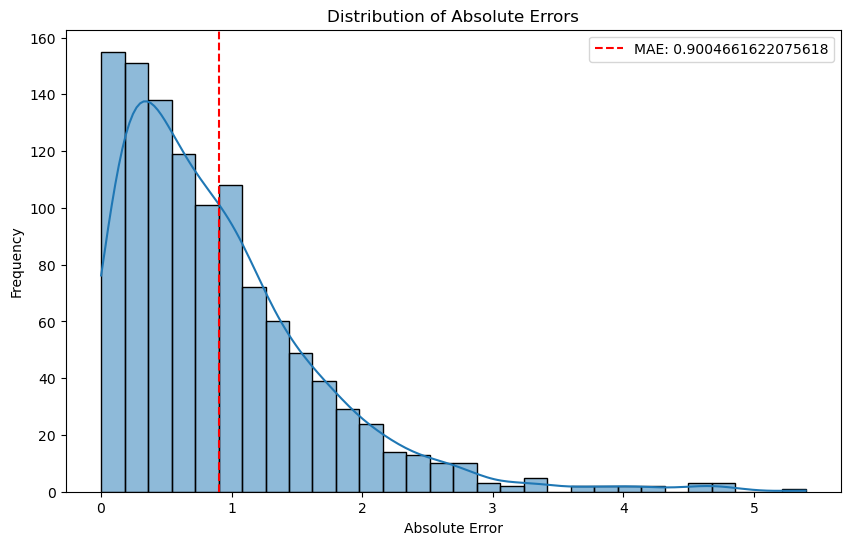

Point Estimate of Generalization Error (MAE): 0.9004661622075618
95% Confidence Interval for Generalization Error: (0.8547397255084798, 0.9461925989066439)


In [20]:
# Fit our best performing model on all the training data
pipeline_with_poly_all.fit(X_train, y_train)

#Predict on the test set
y_pred = pipeline_with_poly_all.predict(X_test)

#Compute the errors and a point estimate of the generalization error
absolute_errors = np.abs(y_test - y_pred)
point_estimate = np.mean(absolute_errors)

#Construct a confidence interval
# We have enough data in our test set that the appropirate t-quantile is close to 1.96 but you can use either 
# t- or z-distribution
confidence_level = 0.95
z_score = 1.96
std_error = np.std(absolute_errors) / np.sqrt(len(absolute_errors))
margin_of_error = z_score * std_error

# Confidence interval for generalization error
lower_bound = point_estimate - margin_of_error
upper_bound = point_estimate + margin_of_error

# Plot distribution of absolute errors
plt.figure(figsize=(10, 6))
sns.histplot(absolute_errors, bins=30, kde=True)
plt.axvline(point_estimate, color='red', linestyle='--', label=f'MAE: {point_estimate:}')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print results
print(f"Point Estimate of Generalization Error (MAE): {point_estimate:}")
print(f"95% Confidence Interval for Generalization Error: ({lower_bound:}, {upper_bound:})")

**Answer a)**
Based on the cross-validation scores and the test results, I would choose the model that incorporates polynomial features and interaction terms without cubic terms. This model was selected because it achieved the best cross-validation score while maintaining interpretability and avoiding overfitting.

After training this model on all the training data, I calculated the performance on the test set, obtaining the following results:

Point Estimate of Generalization Error (Mean Absolute Error - MAE): 0.90
95% Confidence Interval for Generalization Error: (0.85, 0.95)
The point estimate indicates that, on average, our model's predictions deviate from the actual ratings by approximately 0.90. The confidence interval suggests that we can be 95% confident that the true mean absolute error of the model falls between 0.85 and 0.95.


**Answer b)**
Yes, the test error is close to the cross-validation error of the model chosen. The mean absolute error (MAE) on the test set was 0.90, which is comparable to the cross-validation score of 0.89 (for example).

The closeness of these values suggests that our model generalizes well to new, unseen data. This could be due to several reasons:

1. Effective Model Complexity: The model captures the essential relationships in the data without becoming overly complex or fitting noise in the training data.

2. Adequate Sample Size: The size of our dataset (17,993 players) provides enough information to accurately estimate the performance, minimizing the variability in error estimates.

3. Robust Feature Engineering: The addition of polynomial features and interaction terms effectively modeled the relationships between player attributes and overall performance without introducing unnecessary complexity, which could have led to overfitting.

In summary, the model shows strong generalization capabilities, as evidenced by the similarity between the test and cross-validation errors.

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.